In [1]:
import os
import imageio
from IPython.display import display, Image

import numpy as np
from matplotlib import pyplot as plt

# Zadanie 1

In [2]:
class DeterministicAutomaton:    
    def __init__(self, width=100, height=100, init_density=0.5, rule=184, seed=None):
        self.width = width
        self.height = height
        self.init_density = init_density
        self.seed = seed
        
        self.rule_dict = DeterministicAutomaton._generate_rule_dict(rule)

        self.rows = np.empty((height, width), dtype=np.int8)
        self.rows[0] = self._init_row()
    
    def fill_rows(self):
        for row in range(1, self.height):
            self.rows[row] = self._apply_rule(self.rows[row - 1])
        
    def _init_row(self):
        n = int(self.width * self.init_density)
        row = np.zeros(self.width).astype(np.int8)
        row[:n] = 1
        np.random.seed(self.seed)
        return np.random.permutation(row)
    
    def _apply_rule(self, row):
        new_row = np.empty(self.width, dtype=np.int8)
        for i in range(self.width):
            new_row[i] = self._rule_fun((row[i-1], row[i], row[(i+1) % self.width]))
        return new_row
    
    def _rule_fun(self, x):
        return self.rule_dict[x]
    
    @staticmethod
    def _generate_rule_dict(rule):
        rule_arr = list(reversed([int(a) for a in np.binary_repr(rule, width=8)]))
        rule_dict = {}
        for i in range(8):
            rule_dict[tuple(int(a) for a in np.binary_repr(i, width=3))] = rule_arr[i]
        return rule_dict

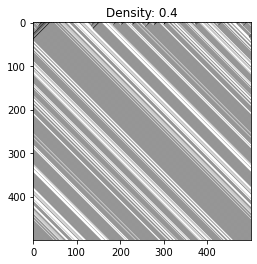

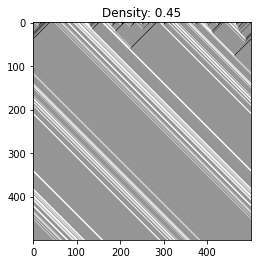

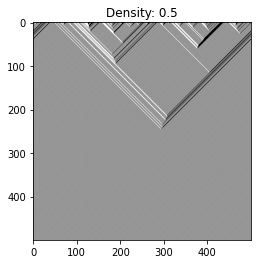

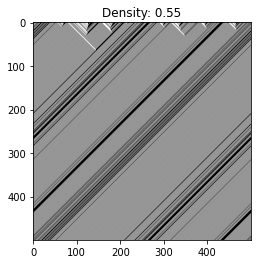

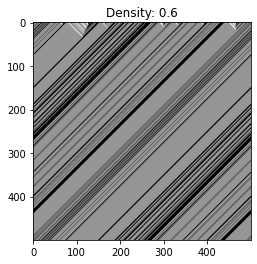

In [3]:
for density in [0.4, 0.45, 0.5, 0.55, 0.6]:
    A = DeterministicAutomaton(width=500, height=500, init_density=density, seed=40)
    A.fill_rows()

    plt.imshow(A.rows, cmap='Greys')
    plt.title(f'Density: {density}')
    plt.show()

W każdym przypadku po początkowym braku uporządkowania, po jakimś czasie można obserwować regularne wzory. Tylko w przypadku gęstości dokładnie 0.5 pojawia się atraktor w postaci szachownicy.

# Zadanie 2

In [4]:
class NSAutomaton(DeterministicAutomaton):
    def __init__(self, L=100, iterations=100, vmax=2, p=0.2, car_density=0.3, seed=None):
        self.L = L
        self.iterations = iterations
        self.vmax = vmax
        self.p = p
        self.car_density = car_density
        self.seed = seed
        
        self.states = np.empty((iterations, self.L), dtype=np.int8)
        self.states[0] = self._init_state()
        
    def fill_states(self):
        for s in range(1, self.iterations):
            self.states[s] = self._apply_turn(self.states[s - 1])
            
    def get_car_map(self):
        car_map = np.zeros((self.iterations, self.L))
        car_map[self.states != -1] = 1
        return car_map
        
    def _init_state(self):
        n = int(self.L * self.car_density)
        row = np.full(self.L, -1).astype(np.int8)
        row[:n] = 0
        np.random.seed(self.seed)
        return np.random.permutation(row)
    
    def _apply_first_rule(self, state):
        new_state = np.full(self.L, -1).astype(np.int8)
        
        # Find the last car
        last_car = self.L - 1
        while last_car >= 0 and state[last_car] == -1:
            last_car -= 1
            
        # Process all the car except for the last one
        i = last_car - 1
        dist = 1
        while i >= 0:
            if state[i] == -1: # not a car
                dist += 1
            else: # car
                new_state[i] = min(state[i] + 1, dist - 1, self.vmax)
                dist = 1
            i -= 1
            
        # Process the last car
        dist += self.L - last_car - 1
        new_state[last_car] = min(state[last_car] + 1, dist - 1, self.vmax)
        
        return new_state
        
    def _apply_second_rule(self, state):
        new_state = np.full(self.L, -1).astype(np.int8)
        for i in range(self.L):
            if state[i] != -1:
                if np.random.uniform() < self.p:
                    new_state[i] = max(state[i] - 1, 0)
                else:
                    new_state[i] = state[i]
        
        return new_state
                    
    def _apply_move(self, state):
        new_state = np.full(self.L, -1).astype(np.int8)
        for i in range(self.L):
            if state[i] != -1:
                new_pos = (i + state[i]) % self.L
                new_state[new_pos] = state[i]
        return new_state
                
    def _apply_turn(self, state):
        state = self._apply_first_rule(state)
        state = self._apply_second_rule(state)
        return self._apply_move(state)

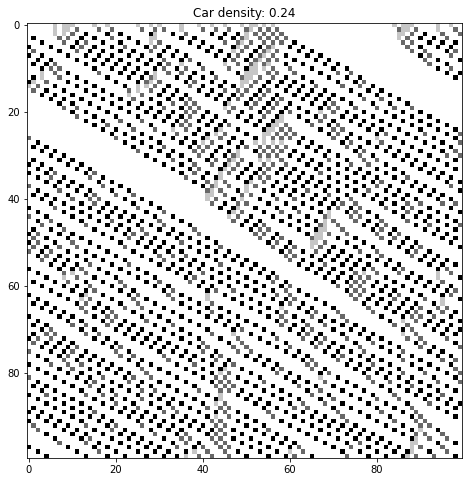

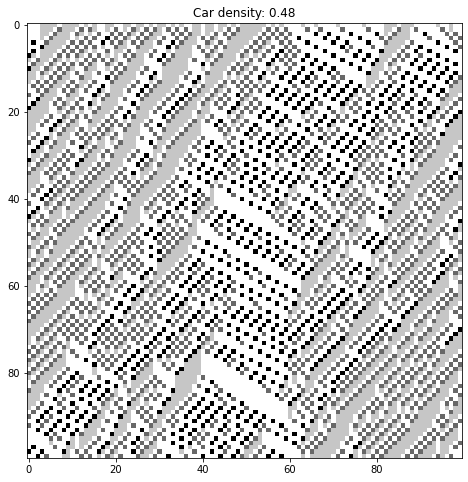

In [5]:
for density in [0.24, 0.48]:
    A = NSAutomaton(car_density=density, seed=42)
    A.fill_states()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(A.states, cmap='Greys')
    # plt.colorbar()
    plt.title(f'Car density: {density}')
    plt.show()

## Gify

In [6]:
def build_gif(states, name, show_gif=True, figsize=(10, 1), vmin=-1, vmax=2):
    if figsize is not None:
        plt.figure(figsize=figsize)
    gif_path = f'gifs/{name}.gif'
    for i, state in enumerate(states):
        # plt.imshow(state.reshape(1, -1), cmap='Greys')
        plt.imshow(np.vstack([state for _ in range(4)]), cmap='Greys', vmin=vmin, vmax=vmax)
        plt.title(f'iteration {i:3}')
        plt.yticks([])
        plt.savefig(f'gifs/{i}.png', dpi=100)
        plt.clf()
        
    with imageio.get_writer(gif_path, mode='I', duration=None) as writer:
        for i in range(len(states)):
            image = imageio.imread(f'gifs/{i}.png')
            writer.append_data(image)
            
    for i in range(len(states)):
        os.remove(f'gifs/{i}.png')
        
    if show_gif:
        # if figsize is not None:
        #     plt.figure(figsize=figsize)
        display(Image(data=open(gif_path, 'rb').read()))

### Gif 1. Mały ruch, nikt nie zwalnia (pojedynczy ruch laminarny)

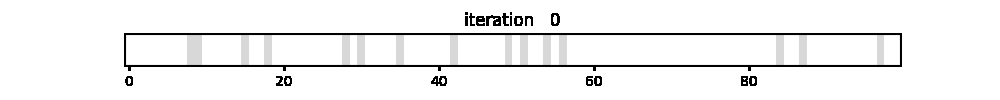

<Figure size 720x72 with 0 Axes>

In [7]:
A = NSAutomaton(vmax=3, p=0, car_density=0.15, seed=42)
A.fill_states()
build_gif(A.states, 'gif_1', vmax=3)

### Gif 2. Mały ruch, duża szansza na zwolnienie - tworzą się fale start-stop

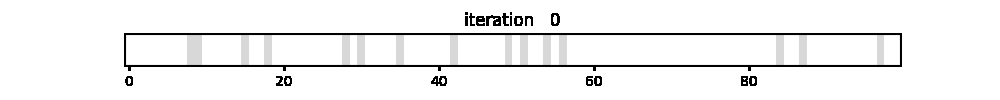

<Figure size 720x72 with 0 Axes>

In [8]:
A = NSAutomaton(vmax=3, p=0.8, car_density=0.15, seed=42)
A.fill_states()
build_gif(A.states, 'gif_2', vmax=3)

### Gif 3. Za duży ruch - korek. Nikt nie osiąga prędkości większej niż 1

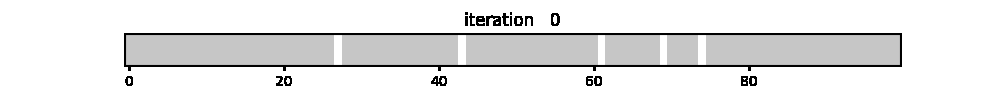

<Figure size 720x72 with 0 Axes>

In [9]:
A = NSAutomaton(vmax=2, p=0, car_density=0.95, seed=42)
A.fill_states()
build_gif(A.states, 'gif_3', vmax=2)

### Gif 4. Korek, bo dużo ludzi zwalnia

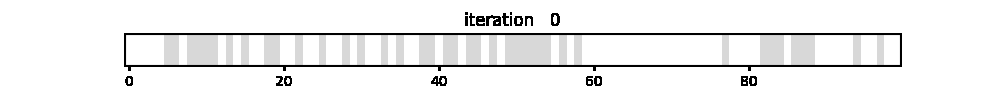

<Figure size 720x72 with 0 Axes>

In [10]:
A = NSAutomaton(vmax=3, p=0.8, car_density=0.4, seed=42)
A.fill_states()
build_gif(A.states, 'gif_4', vmax=3)

### Gif 5. Fala start-stop przesuwająca się w lewo (do tyłu)

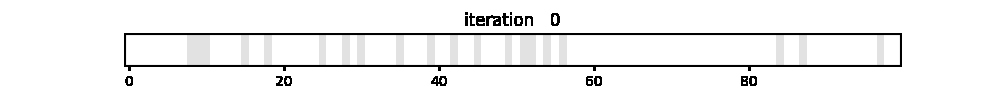

<Figure size 720x72 with 0 Axes>

In [11]:
A = NSAutomaton(iterations=200, vmax=4, p=0.3, car_density=0.2, seed=42)
A.fill_states()
build_gif(A.states, 'gif_5', vmax=4)

### Gif 6. Przeszkoda na drodze

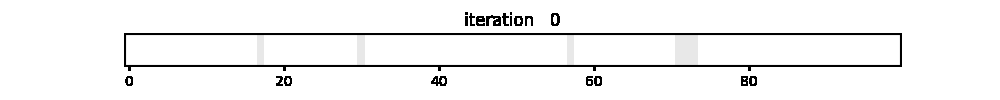

<Figure size 720x72 with 0 Axes>

In [12]:
A = NSAutomaton(iterations=400, vmax=5, p=0.95, car_density=0.06, seed=1234)
A.fill_states()
build_gif(A.states, 'gif_6', vmax=5)